# Build carbon capture storage suitablity layers for GRIDCERF


The following code was used to build the carbon capture storage suitability layers for GRIDCERF. GRIDCERF does not provide the source data directly due to some license restrictions related for direct redistribution of the unaltered source data.  However, the following details the provenance associated with each source dataset and how they were processed.

## 1. Setup environment

### 1.1 Download GRIDCERF

Download the GRIDCERF package if you have not yet done so from here:  https://doi.org/10.57931/2281697.  Please extract GRIDCERF inside the `data` directory of this repository as the paths in this notebook are set to that expectation.


### 1.2 Data description


- **Title**:  Natural Gas Interstate and Intrastate Pipelines
- **Description from Source**: This is a polyline dataset representing the major natural gas transmission pipelines in the U.S. including interstate, intrastate, and gathering pipelines.These data were compiled by the U.S. Energy Information Administration from various sources including FERC Form 567—Annual Report of System Flow Diagrams and Capacity, and other external sources such as company web pages and industry press. Updated January 2020.
- **Source URL**:  https://atlas.eia.gov/datasets/eia::natural-gas-interstate-and-intrastate-pipelines/about
- **Date Accessed**:  9/26/23
- **Citation**
> US Energy Information Administration, 2020. Natural Gas Interstate and Intrastate Pipelines. U.S. Energy Atlas, https://atlas.eia.gov/datasets/eia::natural-gas-interstate-and-intrastate-pipelines/about
- **Application**: Carbon from CCS technologies is stored in saline reservoirs or in connection to a carbon pipeline which transfers it to another storage location. CO2 pipeline infrastructure data is not available publicly, therefore, a proxy suitability layer is created for CO2 pipelines that follows the assumption that they may follow similar paths as existing natural gas pipelines. A subset of the natural gas pipeline locations in states where CO2 pipelines are known to exist plus a buffer of 50km is used to create the corresponding suitability.

____

- **Title**:  NATCARB Atlas Saline Basin 10km Grid
- **Description from Source**: The NATCARB Atlas 10km square grids covers saline basins within all Regional Carbon Sequestration Partnership (RCSP) domains in the US and parts of Canada. Each 10km grid contains information about the saline basin formation below. Attributes associated with each 10km grid are (with (Units, Attribute name) after): Partnership name (PARTNERSHIP) Resource/formation name (RESOURCE_Name) Resource area (square meters, RSC_AREA_C ) CO2 capacity estimate volumes (in metric tons per feature): vol_low (P10), vol_med (P50), and vol_high (P90) (based on Goodman et al. 2011) Depth to top of formation from surface (feet, depth_ft) Formation mean thickness (feet, thickness_) Mean salinity (TDS) (ppm, salinity_t) Mean pressure at top of storage resource (psi, pressure_p) Mean temperature at top of storage resource (degrees F, temperature) Mean porosity (percent, porosity_pct) Mean permeability (mD, permeability_mD) Assessed (1= yes, 0= volume estimates not made)
- **Source URL**:  https://edx.netl.doe.gov/dataset/natcarb-atlas-saline-basin-10km-grid
- **Date Accessed**:  9/26/23
- **Citation**
> National Energy Technology Laboratory, 2022. NATCARB Atlas Saline Basin 10km Grid. https://edx.netl.doe.gov/dataset/natcarb-atlas-saline-basin-10km-grid
- **Application**: Carbon from CCS technologies is stored in saline reservoirs or in connection to a carbon pipeline which transfers it to another storage location. Any geospatial area located above a saline reservoir is considered suitable for carbon storage.


### 1.3 Import modules


In [1]:
import os

import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio
from rasterio import features

## 2. Configuration


In [2]:
# get the parent directory path to where this notebook is currently stored
root_dir = os.path.dirname(os.getcwd())

# data directory in repository
data_dir = os.path.join(root_dir, "data")

# GRIDCERF data directory from downloaded archive
gridcerf_dir = os.path.join(data_dir, "gridcerf")

# GRIDCERF reference data directory
reference_dir = os.path.join(gridcerf_dir, "reference")

# GRIDCERF source data directory for the downloaded data
ng_source_dir = os.path.join(gridcerf_dir, "source", "technology_specific",  'natural_gas_pipelines' )
saline_source_dir = os.path.join(gridcerf_dir, "source", "technology_specific",  'saline_reservoirs' )

# GRIDCERF technology_specific data directory
technology_specific_dir = os.path.join(gridcerf_dir, "technology_specific")

# GRIDCERF compiled final suitability data directory
compiled_dir = os.path.join(gridcerf_dir, "compiled")

# template siting mask raster
template_raster = os.path.join(reference_dir, "gridcerf_sitingmask.tif")

# template conus mask raster
land_mask_raster = os.path.join(reference_dir, "gridcerf_landmask.tif")

# template conus mask raster
conus_mask = os.path.join(reference_dir, "gridcerf_landmask.tif")

# CONUS boundary shapefile
conus_shpfile = os.path.join(reference_dir, "gridcerf_conus_boundary.shp")

# shapefile location for the source airports
ng_pipeline_shpfile = os.path.join(ng_source_dir,'Natural_Gas_Interstate_and_Intrastate_Pipelines-shp',  
                                "NaturalGas_InterIntrastate_Pipelines_US_EIA.shp")

saline_reservoir_shpfile = os.path.join(saline_source_dir, 'Natcarb_Saline_poly_shapefile', 'NATCARB_Saline_Poly_v1502.shp')

# output rasters
output_ccs_file = os.path.join(technology_specific_dir, "gridcerf_carbon_capture_storage_suitability.tif")

# factor for converting a mile to meter
mi_to_meter = 1609.34

# crs for converting projections
crs = 'ESRI:102003'


## 4. Generate suitability rasters

### 4.1 Functions to build suitability

In [3]:
def vector_to_raster(template_raster, land_mask_raster, gdf, value_field, output_raster):
                     
    # open the template raster and extract metadata and land mask
    with rasterio.open(template_raster) as template:

        metadata = template.meta.copy()

        # update raster data type
        metadata.update(dtype=np.int16)

        # extract land mask
        land_mask_file = rasterio.open(land_mask_raster)
        land_mask = land_mask_file.read(1)
        land_mask = np.where(land_mask == 0, np.nan, 1)

        # write output raster
        with rasterio.open(output_raster, 'w+', **metadata) as out:

            out_arr = out.read(1)

            # build shapes to rasterize from target geometry and field
            shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf[value_field]))

            # burn features
            burned = features.rasterize(shapes=shapes, 
                                        fill=0, 
                                        out=out_arr, 
                                        transform=out.transform)
            
            burned = np.where(burned == 1, 1, 0).astype(np.float64)

            # invert suitability
            burned = np.where(burned ==1, 0, 1).astype(np.float64)
            
            # apply land mask
            burned *= land_mask
            
            # make nan excluded
            burned = np.where(np.isnan(burned), 1, burned)

            out.write_band(1, burned.astype(np.int16))


### 4.2 Generate suitability

In [4]:
# read in GRIDCERF boundary shapefile
bdf = gpd.read_file(conus_shpfile)

#### 4.2.1 Prepare Natural Gas Pipeline Data

<Axes: >

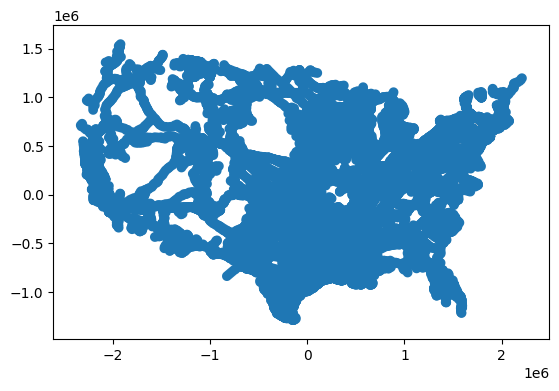

In [5]:
# read in shapefile and project to our GRIDCERF projection
ng_gdf = gpd.read_file(ng_pipeline_shpfile).to_crs(crs=crs)

# only keep areas within our GRIDCERF boundary
ng_gdf = gpd.clip(ng_gdf, bdf)

# add field to use for rasterization
ng_gdf["value"] = 1

# generate areas buffered by 50 km
ng_gdf["geometry"] = ng_gdf.buffer(50 * 1000)

ng_gdf.plot()

#### 4.2.2. Prepare Saline Reservoir Data

<Axes: >

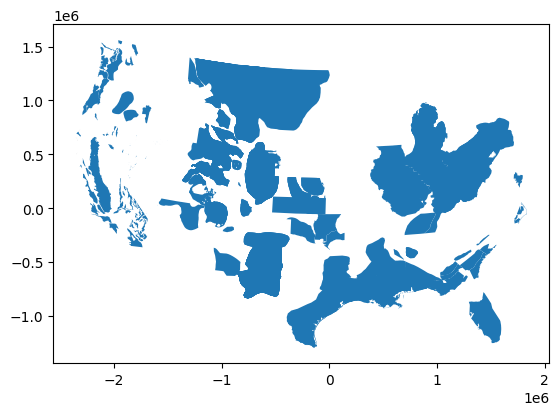

In [6]:
# read in shapefile and project to our GRIDCERF projection
saline_gdf = gpd.read_file(saline_reservoir_shpfile).to_crs(crs=crs)

# only keep areas within our GRIDCERF boundary
saline_gdf = gpd.clip(saline_gdf, bdf)

# add field to use for rasterization
saline_gdf["value"] = 1

saline_gdf.plot()

#### 4.2.3 Combine Shapefiles

<Axes: >

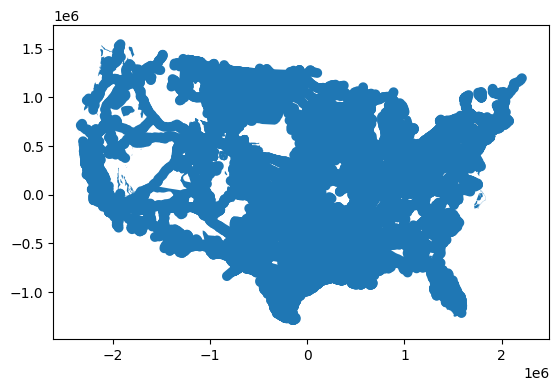

In [7]:
# combine shapefiles into single shapefile
combined_gdf = pd.concat([ng_gdf, saline_gdf])

# Convert back into geodataframe
combined_gdf = gpd.GeoDataFrame(combined_gdf, geometry=combined_gdf['geometry'])

combined_gdf.plot()

In [8]:
# generate raster
vector_to_raster(template_raster=template_raster, 
                 land_mask_raster=template_raster,
                 gdf=combined_gdf, 
                 value_field="value",
                 output_raster=output_ccs_file)